# Machine Learning Trader

In [96]:
# Import Libraries

from __future__ import division
import pandas as pd
from pandas_datareader import data
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
import finta
import pandas_datareader.data as web
import datetime
from pandas.plotting import scatter_matrix
import yfinance as yf
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss, zero_one_loss, matthews_corrcoef, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Import CSV file and create pandas DataFrame

In [2]:
# # Define Get function for YFinance ticker data
# def get(tickers, start_date, end_date):
#   def data(ticker):
#     return (web.DataReader(ticker, data_source='yahoo', start=start_date, end=end_date))
#   datas = map (data, tickers)
#   return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

# #Assign tickers list
# tickers = ['L.TO', 'BMO.TO', 'TRI.TO','CIX.TO']
# #Get ticker data
# stocks_df = get(tickers, datetime.datetime(2019, 1, 1), datetime.datetime(2022, 3, 2))

In [3]:
#Read in Data from CSVs
loblaw_path = Path("./Resources/loblaw.csv")
loblaw_data = pd.read_csv(loblaw_path, parse_dates = True, index_col='Date', infer_datetime_format=True)
tri_path =  Path("./Resources/tri.csv")
tri_data = pd.read_csv(tri_path, parse_dates = True, index_col='Date', infer_datetime_format=True)
cix_path =  Path("./Resources/cix.csv")
cix_data = pd.read_csv(cix_path, parse_dates = True, index_col='Date', infer_datetime_format=True)
bmo_path = Path("./Resources/bmo.csv")
bmo_data = pd.read_csv(bmo_path, parse_dates = True, index_col='Date', infer_datetime_format=True)

#Create ticker_list to prepare for FOR Loop
ticker_list = {"L.TO":loblaw_data, "BMO.TO":bmo_data, "TRI.TO": tri_data, "CIX.TO": cix_data}

In [4]:
#Create multi-index DataFrame for coding effiency
tickers = ['L.TO', 'BMO.TO', 'TRI.TO','CIX.TO']
stocks_df = pd.concat([loblaw_data, bmo_data, tri_data, cix_data], keys=tickers, names=['Ticker', 'Date'])

## Visualize Stock Data

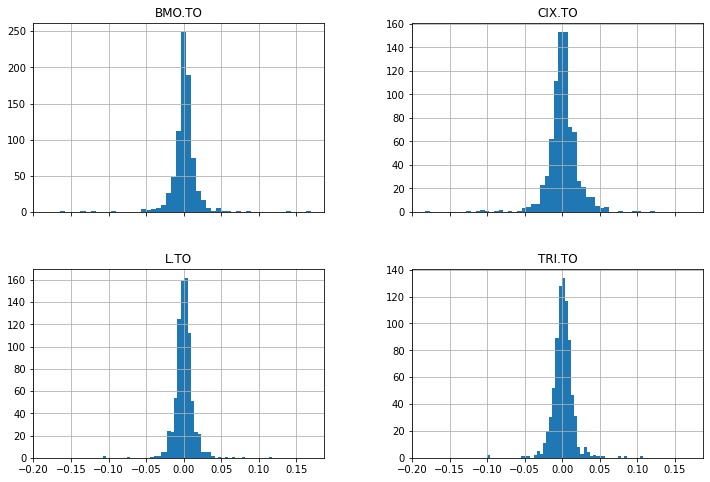

In [5]:
# Isolate the Close values and transform the DataFrame
daily_close = stocks_df[['Close']].reset_index().pivot('Date', 'Ticker', 'Close')

# Calculate the daily percentage change for `daily_close`
daily_pct_change = daily_close.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

In [70]:
# Plot Closing Prices
display(signals_df.loc['L.TO']['Close'].hvplot(title='L.TO Close Prices'))
display(signals_df.loc['BMO.TO']['Close'].hvplot(title='BMO.TO Close Prices'))
display(signals_df.loc['TRI.TO']['Close'].hvplot(title='TRI.TO Close Prices'))
display(signals_df.loc['CIX.TO']['Close'].hvplot(title='CIX.TO Close Prices'))

:Curve   [Date]   (Close)

:Curve   [Date]   (Close)

:Curve   [Date]   (Close)

:Curve   [Date]   (Close)

## Create Signals DataDrame for DMAC Strategy Baseline Strategy to compare with Machine Learning Strategy Results

In [7]:
#Create signals DataFrame
signals_df = stocks_df

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
L.TO   2019-01-03  60.770000  61.110001  60.369999  60.669998  57.458572   
       2019-01-04  60.930000  61.290001  60.509998  60.799999  57.581692   
       2019-01-07  61.000000  61.599998  60.470001  61.369999  58.121513   
       2019-01-08  61.549999  62.090000  61.310001  61.849998  58.576099   
       2019-01-09  61.860001  62.650002  61.840000  62.480000  59.172760   

                   Volume  Actual Returns  
Ticker Date                                
L.TO   2019-01-03  617800       -0.006224  
       2019-01-04  444100        0.002143  
       2019-01-07  724700        0.009375  
       2019-01-08  601100        0.007821  
       2019-01-09  643000        0.010186

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
CIX.TO 2022-02-24  19.990000  20.600000  19.650000  20.430000  20.430000   
       2022-02-25  20.680000  21.000000  20.450001  20.930000  20.930000   
       2022-02-28  20.700001  20.980000  20.420000  20.750000  20.750000   
       2022-03-01  20.850000  20.850000  20.219999  20.410000  20.410000   
       2022-03-02  20.420000  21.059999  20.420000  20.969999  20.969999   

                    Volume  Actual Returns  
Ticker Date                                 
CIX.TO 2022-02-24  1290700       -0.013520  
       2022-02-25   710700        0.024474  
       2022-02-28  1152000       -0.008600  
       2022-03-01   878300       -0.016386  
       2022-03-02   825700        0.027438

In [8]:
# Slice to just the close column
# signals_df = signals_df.loc[:,['Close']].copy()
signals_df = signals_df.copy()
# Set the short window and long window
short_window = 50
long_window = 100

# Generate the fast and slow simple moving averages (50 and 100 days, respectively)
signals_df['SMA_Short'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Long'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
L.TO   2019-05-27  70.010002  70.610001  70.010002  70.379997  66.958961   
       2019-05-28  70.000000  70.860001  69.589996  70.790001  67.349007   
       2019-05-29  70.459999  70.470001  69.360001  69.580002  66.197838   
       2019-05-30  69.440002  69.830002  69.019997  69.339996  65.969513   
       2019-05-31  69.239998  69.709999  68.989998  69.360001  65.988548   

                    Volume  Actual Returns  SMA_Short  SMA_Long  
Ticker Date                                                      
L.TO   2019-05-27   529800        0.006003    66.7890   65.6726  
       2019-05-28  1146000        0.005826    66.8916   65.7738  
       2019-05-29   675300       -0.017093    66.9738   65.8616  
       2019-05-30   467500       -0.003449    67.0580   65.9413  
       2019-05-31   645500        0.000288    67.1514   66.0164

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
CIX.TO 2022-02-24  19.990000  20.600000  19.650000  20.430000  20.430000   
       2022-02-25  20.680000  21.000000  20.450001  20.930000  20.930000   
       2022-02-28  20.700001  20.980000  20.420000  20.750000  20.750000   
       2022-03-01  20.850000  20.850000  20.219999  20.410000  20.410000   
       2022-03-02  20.420000  21.059999  20.420000  20.969999  20.969999   

                    Volume  Actual Returns  SMA_Short  SMA_Long  
Ticker Date                                                      
CIX.TO 2022-02-24  1290700       -0.013520    24.7728   26.5352  
       2022-02-25   710700        0.024474    24.6516   26.4863  
       2022-02-28  1152000       -0.008600    24.5390   26.4400  
       2022-03-01   878300       -0.016386    24.4180   26.3883  
       2022-03-02   825700        0.027438    24.3046   26.3444

In [10]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

#Create signals
signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA_Short'][short_window:] > signals_df['SMA_Long'][short_window:], 1.0, 0.0
)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

/Users/tyesondemets/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
L.TO   2019-05-27  70.010002  70.610001  70.010002  70.379997  66.958961   
       2019-05-28  70.000000  70.860001  69.589996  70.790001  67.349007   
       2019-05-29  70.459999  70.470001  69.360001  69.580002  66.197838   
       2019-05-30  69.440002  69.830002  69.019997  69.339996  65.969513   
       2019-05-31  69.239998  69.709999  68.989998  69.360001  65.988548   

                    Volume  Actual Returns  SMA_Short  SMA_Long  Signal  
Ticker Date                                                              
L.TO   2019-05-27   529800        0.006003    66.7890   65.6726     0.0  
       2019-05-28  1146000        0.005826    66.8916   65.7738     0.0  
       2019-05-29   675300       -0.017093    66.9738   65.8616     0.0  
       2019-05-30   467500       -0.003449    67.0580   65.9413     0.0  
       2019-05-31   645500        0.000288    67.1514   66.0164     0.0

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
CIX.TO 2022-02-24  19.990000  20.600000  19.650000  20.430000  20.430000   
       2022-02-25  20.680000  21.000000  20.450001  20.930000  20.930000   
       2022-02-28  20.700001  20.980000  20.420000  20.750000  20.750000   
       2022-03-01  20.850000  20.850000  20.219999  20.410000  20.410000   
       2022-03-02  20.420000  21.059999  20.420000  20.969999  20.969999   

                    Volume  Actual Returns  SMA_Short  SMA_Long  Signal  
Ticker Date                                                              
CIX.TO 2022-02-24  1290700       -0.013520    24.7728   26.5352     0.0  
       2022-02-25   710700        0.024474    24.6516   26.4863     0.0  
       2022-02-28  1152000       -0.008600    24.5390   26.4400     0.0  
       2022-03-01   878300       -0.016386    24.4180   26.3883     0.0  
       2022-03-02   825700        0.027438    24.3046   26.3444     0.0

In [11]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['DMAC Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

#Check DataFrame
signals_df.head()

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
L.TO   2019-05-27  70.010002  70.610001  70.010002  70.379997  66.958961   
       2019-05-28  70.000000  70.860001  69.589996  70.790001  67.349007   
       2019-05-29  70.459999  70.470001  69.360001  69.580002  66.197838   
       2019-05-30  69.440002  69.830002  69.019997  69.339996  65.969513   
       2019-05-31  69.239998  69.709999  68.989998  69.360001  65.988548   

                    Volume  Actual Returns  SMA_Short  SMA_Long  Signal  \
Ticker Date                                                               
L.TO   2019-05-27   529800        0.006003    66.7890   65.6726     0.0   
       2019-05-28  1146000        0.005826    66.8916   65.7738     0.0   
       2019-05-29   675300       -0.017093    66.9738   65.8616     0.0   
       2019-05-30   467500       -0.003449    67.0580   65.9413     0.0   
       2019-05-31   645500        0.000288    67.1514   66.0164     0.0   

                   DMAC Returns  
Ticker Date                      
L.TO   2019-05-27           NaN  
       2019-05-28           0.0  
       2019-05-29          -0.0  
       2019-05-30          -0.0  
       2019-05-31           0.0

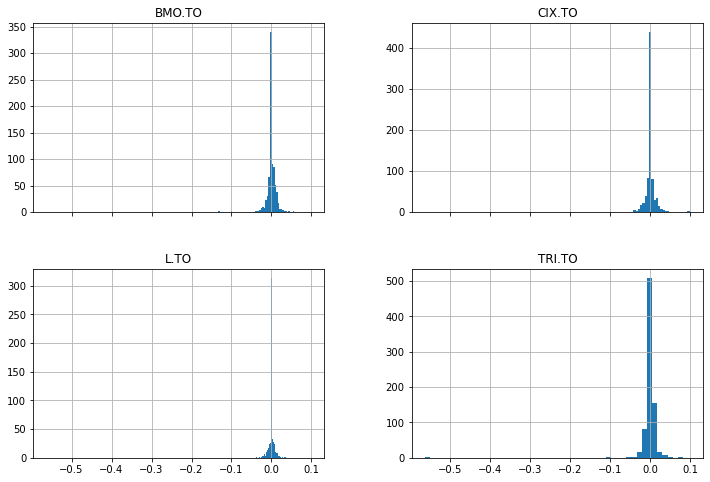

In [12]:
# Isolate the Close values and transform the DataFrame
strategy_returns = signals_df[['DMAC Returns']].reset_index().pivot('Date', 'Ticker', 'DMAC Returns')

# Calculate the daily percentage change for `daily_close_plot`
daily_pct_change = strategy_returns.pct_change()

# Plot the distributions
strategy_returns.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

In [13]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
signals_df.tail()

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
CIX.TO 2022-02-24  19.990000  20.600000  19.650000  20.430000  20.430000   
       2022-02-25  20.680000  21.000000  20.450001  20.930000  20.930000   
       2022-02-28  20.700001  20.980000  20.420000  20.750000  20.750000   
       2022-03-01  20.850000  20.850000  20.219999  20.410000  20.410000   
       2022-03-02  20.420000  21.059999  20.420000  20.969999  20.969999   

                    Volume  Actual Returns  SMA_Short  SMA_Long  Signal  \
Ticker Date                                                               
CIX.TO 2022-02-24  1290700       -0.013520    24.7728   26.5352     0.0   
       2022-02-25   710700        0.024474    24.6516   26.4863     0.0   
       2022-02-28  1152000       -0.008600    24.5390   26.4400     0.0   
       2022-03-01   878300       -0.016386    24.4180   26.3883     0.0   
       2022-03-02   825700        0.027438    24.3046   26.3444     0.0   

                   DMAC Returns  Entry/Exit  
Ticker Date                                  
CIX.TO 2022-02-24          -0.0         0.0  
       2022-02-25           0.0         0.0  
       2022-02-28          -0.0         0.0  
       2022-03-01          -0.0         0.0  
       2022-03-02           0.0         0.0

In [14]:
# Visualize exit position relative to close price
exit = signals_df.loc['L.TO'][signals_df.loc['L.TO']['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df.loc['L.TO'][signals_df.loc['L.TO']['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df.loc['L.TO'][['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df.loc['L.TO'][['SMA_Short', 'SMA_Long']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="L.TO - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [15]:
# Visualize exit position relative to close price
exit = signals_df.loc['BMO.TO'][signals_df.loc['BMO.TO']['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='green',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df.loc['BMO.TO'][signals_df.loc['BMO.TO']['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='red',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df.loc['BMO.TO'][['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df.loc['BMO.TO'][['SMA_Short', 'SMA_Long']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="BMO.TO - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [16]:
# Visualize exit position relative to close price
exit = signals_df.loc['TRI.TO'][signals_df.loc['TRI.TO']['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='green',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df.loc['TRI.TO'][signals_df.loc['TRI.TO']['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='red',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df.loc['TRI.TO'][['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df.loc['TRI.TO'][['SMA_Short', 'SMA_Long']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="TRI.TO - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [17]:
# Visualize exit position relative to close price
exit = signals_df.loc['CIX.TO'][signals_df.loc['CIX.TO']['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='green',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df.loc['CIX.TO'][signals_df.loc['CIX.TO']['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='red',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df.loc['CIX.TO'][['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df.loc['CIX.TO'][['SMA_Short', 'SMA_Long']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="CIX.TO - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [18]:
# Assign variables to plot Strategy Returns for performance examination
l_dmac_returns = (1 + signals_df.loc['L.TO']['DMAC Returns']).cumprod().hvplot(title='L.TO DMAC Returns')
bmo_dmac_returns = (1 + signals_df.loc['BMO.TO']['DMAC Returns']).cumprod().hvplot(title='BMO.TO DMAC Returns')
tri_dmac_returns = (1 + signals_df.loc['TRI.TO']['DMAC Returns']).cumprod().hvplot(title='TRI.TO DMAC Returns')
cix_dmac_returns = (1 + signals_df.loc['CIX.TO']['DMAC Returns']).cumprod().hvplot(title='CIX.TO DMAC Returns')
l_actual_returns = (1 + signals_df.loc['L.TO']['DMAC Returns']).cumprod().hvplot(title='L.TO Actual Returns')
bmo_actual_returns = (1 + signals_df.loc['BMO.TO']['DMAC Returns']).cumprod().hvplot(title='BMO.TO Actual Returns')
tri_actual_returns = (1 + signals_df.loc['TRI.TO']['DMAC Returns']).cumprod().hvplot(title='TRI.TO Actual Returns')
cix_actual_returns = (1 + signals_df.loc['CIX.TO']['DMAC Returns']).cumprod().hvplot(title='CIX.TO Actual Returns')

In [19]:
#Display Cumulative Returns
display(l_dmac_returns)
display(bmo_dmac_returns)
display(tri_dmac_returns)
display(cix_dmac_returns)

:Curve   [Date]   (DMAC Returns)

:Curve   [Date]   (DMAC Returns)

:Curve   [Date]   (DMAC Returns)

:Curve   [Date]   (DMAC Returns)

In [20]:
# Assign X Variables
# X_l = loblaw_data.copy()
# X_bmo = bmo_data.copy()
# X_tri = tri_data.copy()
# X_cix =cix_data.copy()

In [21]:
#Calculate some volume based indicators into the dataframe
#accuracy = {}
for ticker in ticker_list:
    stock_data = ticker_list['L.TO'].copy()
    # stock_data['SMA'] = finta.TA.SMA(stock_data)
    # stock_data['SMM'] = finta.TA.SMM(stock_data)
    # stock_data['SSMA'] = finta.TA.SSMA(stock_data)
    # stock_data['EMA'] = finta.TA.EMA(stock_data)
    # stock_data['DEMA'] = finta.TA.DEMA(stock_data)
    # stock_data['TEMA'] = finta.TA.TEMA(stock_data)
    # stock_data['TRIMA'] = finta.TA.TRIMA(stock_data)
    # stock_data['TRIX'] = finta.TA.TRIX(stock_data)
    # stock_data['VAMA'] = finta.TA.VAMA(stock_data)
    # stock_data['ER'] = finta.TA.ER(stock_data)
    # stock_data['KAMA'] = finta.TA.KAMA(stock_data)
    # stock_data['ZLEMA'] = finta.TA.ZLEMA(stock_data)
    # stock_data['WMA'] = finta.TA.WMA(stock_data)
    # stock_data['HMA'] = finta.TA.HMA(stock_data)
    # stock_data['EVWMA'] = finta.TA.EVWMA(stock_data)
    # stock_data['VWAP'] = finta.TA.VWAP(stock_data)
    # stock_data['SMMA'] = finta.TA.SMMA(stock_data)
    # stock_data['FRAMA'] = finta.TA.FRAMA(stock_data)
    # #stock_data['MACD'] = finta.TA.MACD(stock_data)
    # #stock_data['PPO'] = finta.TA.PPO(stock_data)
    # #stock_data['VW_MACD'] = finta.TA.VW_MACD(stock_data)
    # #stock_data['EV_MACD'] = finta.TA.EV_MACD(stock_data)
    # stock_data['MOM'] = finta.TA.MOM(stock_data)
    # stock_data['ROC'] = finta.TA.ROC(stock_data)
    # stock_data['RSI'] = finta.TA.RSI(stock_data)
    # stock_data['IFT_RSI'] = finta.TA.IFT_RSI(stock_data)
    # stock_data['TR'] = finta.TA.TR(stock_data)
    # stock_data['ATR'] = finta.TA.ATR(stock_data)
    # stock_data['SAR'] = finta.TA.SAR(stock_data)
    # #stock_data['BBANDS'] = finta.TA.BBANDS(stock_data)
    # stock_data['BBWIDTH'] = finta.TA.BBWIDTH(stock_data)
    # #stock_data['MOBO'] = finta.TA.MOBO(stock_data)
    # stock_data['PERCENT_B'] = finta.TA.PERCENT_B(stock_data)
    # #stock_data['KC'] = finta.TA.KC(stock_data)
    # #stock_data['DO'] = finta.TA.DO(stock_data)
    # #stock_data['DMI'] = finta.TA.DMI(stock_data)
    # stock_data['ADX'] = finta.TA.ADX(stock_data)
    # #stock_data['PIVOT'] = finta.TA.PIVOT(stock_data)
    # #stock_data['PIVOT_FIB'] = finta.TA.PIVOT_FIB(stock_data)
    # stock_data['STOCH'] = finta.TA.STOCH(stock_data)
    # stock_data['STOCHD'] = finta.TA.STOCHD(stock_data)
    # stock_data['STOCHRSI'] = finta.TA.STOCHRSI(stock_data)
    # stock_data['WILLIAMS'] = finta.TA.WILLIAMS(stock_data)
    # stock_data['UO'] = finta.TA.UO(stock_data)
    # stock_data['AO'] = finta.TA.AO(stock_data)
    # stock_data['MI'] = finta.TA.MI(stock_data)
    # #stock_data['VORTEX'] = finta.TA.VORTEX(stock_data)
    # #stock_data['KST'] = finta.TA.KST(stock_data)
    # #stock_data['TSI'] = finta.TA.TSI(stock_data)
    # stock_data['TP'] = finta.TA.TP(stock_data)
    # stock_data['ADL'] = finta.TA.ADL(stock_data)
    # stock_data['CHAIKIN'] = finta.TA.CHAIKIN(stock_data)
    # stock_data['MFI'] = finta.TA.MFI(stock_data)
    # stock_data['OBV'] = finta.TA.OBV(stock_data)
    # stock_data['WOBV'] = finta.TA.WOBV(stock_data)
    # stock_data['VZO'] = finta.TA.VZO(stock_data)
    # stock_data['PZO'] = finta.TA.PZO(stock_data)
    # stock_data['EFI'] = finta.TA.EFI(stock_data)
    # stock_data['CFI'] = finta.TA.CFI(stock_data)
    # #stock_data['EBBP'] = finta.TA.EBBP(stock_data)
    # stock_data['EMV'] = finta.TA.EMV(stock_data)
    # stock_data['CCI'] = finta.TA.CCI(stock_data)
    # stock_data['COPP'] = finta.TA.COPP(stock_data)
    # #stock_data['BASP'] = finta.TA.BASP(stock_data)
    # #stock_data['BASPN'] = finta.TA.BASPN(stock_data)
    # stock_data['CMO'] = finta.TA.CMO(stock_data)
    # #stock_data['CHANDELIER'] = finta.TA.CHANDELIER(stock_data)
    # stock_data['QSTICK'] = finta.TA.QSTICK(stock_data)
    # #stock_data['TMF'] = finta.TA.TMF(stock_data)
    # #stock_data['WTO'] = finta.TA.WTO(stock_data)
    # stock_data['FISH'] = finta.TA.FISH(stock_data)
    # #stock_data['ICHIMOKU'] = finta.TA.ICHIMOKU(stock_data)
    # #stock_data['APZ'] = finta.TA.APZ(stock_data)
    # stock_data['SQZMI'] = finta.TA.SQZMI(stock_data)
    # stock_data['VPT'] = finta.TA.VPT(stock_data)
    # stock_data['FVE'] = finta.TA.FVE(stock_data)
    # stock_data['VFI'] = finta.TA.VFI(stock_data)
    # stock_data['MSD'] = finta.TA.MSD(stock_data)
    # stock_data['STC'] = finta.TA.STC(stock_data)
    #stock_data['WAVEPM'] = finta.TA.WAVEPM(stock_data)
    stock_data['SMA5'] = finta.TA.SMA(stock_data,5)
    stock_data['SMM5'] = finta.TA.SMM(stock_data,5)
    stock_data['SMA20'] = finta.TA.SMA(stock_data,20)
    stock_data['SMM20'] = finta.TA.SMM(stock_data,20)
    #stock_data['SMA50'] = finta.TA.SMA(stock_data,50)
    #stock_data['SMM50'] = finta.TA.SMM(stock_data,50)
    stock_data['mfi5'] = finta.TA.MFI(stock_data,5)
    stock_data['mfi20'] = finta.TA.MFI(stock_data,20)
    #stock_data['mfi50'] = finta.TA.MFI(stock_data,50)
    stock_data['mom5'] = finta.TA.MOM(stock_data,5)
    stock_data['mom20'] = finta.TA.MOM(stock_data,20)
    #stock_data['mom50'] = finta.TA.MOM(stock_data,50)
    stock_data['rsi5'] = finta.TA.RSI(stock_data,5)
    stock_data['rsi20'] = finta.TA.RSI(stock_data,20)
    #stock_data['rsi50'] = finta.TA.RSI(stock_data,50)
    stock_data['chaikin5'] = finta.TA.CHAIKIN(stock_data,5)
    stock_data['chaikin20'] = finta.TA.CHAIKIN(stock_data,20)
    #stock_data['chaikin50'] = finta.TA.CHAIKIN(stock_data,50)
    #https://www.investopedia.com/top-7-technical-analysis-tools-4773275
    #stock_data['obv'] = finta.TA.OBV(stock_data)
    stock_data['adl'] = finta.TA.ADL(stock_data)
    stock_data['adx5'] = finta.TA.ADX(stock_data,5)
    stock_data['adx20'] = finta.TA.ADX(stock_data,20)
    #stock_data['adx50'] = finta.TA.ADX(stock_data,50)
    #stock_data['macd'] = finta.TA.MACD(stock_data)
    stock_data['stoch'] = finta.TA.STOCH(stock_data)
    #High minus low = new feature (custom loss functions for predictions)
    #window_size = 20
    #window_to_adjust = 'Volume'
    #window_name = window_to_adjust + str(window_size) 
    #stock_data[window_name] = stock_data[window_to_adjust].rolling(window=window_size).mean().pct_change().shift(-window_size)
    stock_data.dropna(inplace = True)
    stock_data['close_change'] = stock_data['Close'].pct_change().shift(-1)
    stock_data['Signal'] = np.where(
    stock_data['close_change'] > 0, 1.0, 0.0)
    # if ticker_list['L.TO']:
    #     l_features_df = stock_data.copy()
    # elif ticker_list['BMO.TO']:
    #     bmo_features_df = stock_data.copy()
    # elif ticker_list['TRI.TO']:
    #     tri_features_df = stock_data.copy()
    # elif ticker_list['CIX.TO']:
    #     cix_features_df = stock_data.copy()
    # full_df = stock_data.copy()
    # for ticker in ticker_list:
    #     ticker_list = {"L.TO":full_df, "BMO.TO":full_df, "TRI.TO": full_df, "CIX.TO": full_df}
    X_l = stock_data.copy()
    X_l.to_csv("X_l.csv")

In [22]:
for ticker in ticker_list:
    stock_data = ticker_list['BMO.TO'].copy()
    # stock_data['SMA'] = finta.TA.SMA(stock_data)
    # stock_data['SMM'] = finta.TA.SMM(stock_data)
    # stock_data['SSMA'] = finta.TA.SSMA(stock_data)
    # stock_data['EMA'] = finta.TA.EMA(stock_data)
    # stock_data['DEMA'] = finta.TA.DEMA(stock_data)
    # stock_data['TEMA'] = finta.TA.TEMA(stock_data)
    # stock_data['TRIMA'] = finta.TA.TRIMA(stock_data)
    # stock_data['TRIX'] = finta.TA.TRIX(stock_data)
    # stock_data['VAMA'] = finta.TA.VAMA(stock_data)
    # stock_data['ER'] = finta.TA.ER(stock_data)
    # stock_data['KAMA'] = finta.TA.KAMA(stock_data)
    # stock_data['ZLEMA'] = finta.TA.ZLEMA(stock_data)
    # stock_data['WMA'] = finta.TA.WMA(stock_data)
    # stock_data['HMA'] = finta.TA.HMA(stock_data)
    # stock_data['EVWMA'] = finta.TA.EVWMA(stock_data)
    # stock_data['VWAP'] = finta.TA.VWAP(stock_data)
    # stock_data['SMMA'] = finta.TA.SMMA(stock_data)
    # stock_data['FRAMA'] = finta.TA.FRAMA(stock_data)
    # #stock_data['MACD'] = finta.TA.MACD(stock_data)
    # #stock_data['PPO'] = finta.TA.PPO(stock_data)
    # #stock_data['VW_MACD'] = finta.TA.VW_MACD(stock_data)
    # #stock_data['EV_MACD'] = finta.TA.EV_MACD(stock_data)
    # stock_data['MOM'] = finta.TA.MOM(stock_data)
    # stock_data['ROC'] = finta.TA.ROC(stock_data)
    # stock_data['RSI'] = finta.TA.RSI(stock_data)
    # stock_data['IFT_RSI'] = finta.TA.IFT_RSI(stock_data)
    # stock_data['TR'] = finta.TA.TR(stock_data)
    # stock_data['ATR'] = finta.TA.ATR(stock_data)
    # stock_data['SAR'] = finta.TA.SAR(stock_data)
    # #stock_data['BBANDS'] = finta.TA.BBANDS(stock_data)
    # stock_data['BBWIDTH'] = finta.TA.BBWIDTH(stock_data)
    # #stock_data['MOBO'] = finta.TA.MOBO(stock_data)
    # stock_data['PERCENT_B'] = finta.TA.PERCENT_B(stock_data)
    # #stock_data['KC'] = finta.TA.KC(stock_data)
    # #stock_data['DO'] = finta.TA.DO(stock_data)
    # #stock_data['DMI'] = finta.TA.DMI(stock_data)
    # stock_data['ADX'] = finta.TA.ADX(stock_data)
    # #stock_data['PIVOT'] = finta.TA.PIVOT(stock_data)
    # #stock_data['PIVOT_FIB'] = finta.TA.PIVOT_FIB(stock_data)
    # stock_data['STOCH'] = finta.TA.STOCH(stock_data)
    # stock_data['STOCHD'] = finta.TA.STOCHD(stock_data)
    # stock_data['STOCHRSI'] = finta.TA.STOCHRSI(stock_data)
    # stock_data['WILLIAMS'] = finta.TA.WILLIAMS(stock_data)
    # stock_data['UO'] = finta.TA.UO(stock_data)
    # stock_data['AO'] = finta.TA.AO(stock_data)
    # stock_data['MI'] = finta.TA.MI(stock_data)
    # #stock_data['VORTEX'] = finta.TA.VORTEX(stock_data)
    # #stock_data['KST'] = finta.TA.KST(stock_data)
    # #stock_data['TSI'] = finta.TA.TSI(stock_data)
    # stock_data['TP'] = finta.TA.TP(stock_data)
    # stock_data['ADL'] = finta.TA.ADL(stock_data)
    # stock_data['CHAIKIN'] = finta.TA.CHAIKIN(stock_data)
    # stock_data['MFI'] = finta.TA.MFI(stock_data)
    # stock_data['OBV'] = finta.TA.OBV(stock_data)
    # stock_data['WOBV'] = finta.TA.WOBV(stock_data)
    # stock_data['VZO'] = finta.TA.VZO(stock_data)
    # stock_data['PZO'] = finta.TA.PZO(stock_data)
    # stock_data['EFI'] = finta.TA.EFI(stock_data)
    # stock_data['CFI'] = finta.TA.CFI(stock_data)
    # #stock_data['EBBP'] = finta.TA.EBBP(stock_data)
    # stock_data['EMV'] = finta.TA.EMV(stock_data)
    # stock_data['CCI'] = finta.TA.CCI(stock_data)
    # stock_data['COPP'] = finta.TA.COPP(stock_data)
    # #stock_data['BASP'] = finta.TA.BASP(stock_data)
    # #stock_data['BASPN'] = finta.TA.BASPN(stock_data)
    # stock_data['CMO'] = finta.TA.CMO(stock_data)
    # #stock_data['CHANDELIER'] = finta.TA.CHANDELIER(stock_data)
    # stock_data['QSTICK'] = finta.TA.QSTICK(stock_data)
    # #stock_data['TMF'] = finta.TA.TMF(stock_data)
    # #stock_data['WTO'] = finta.TA.WTO(stock_data)
    # stock_data['FISH'] = finta.TA.FISH(stock_data)
    # #stock_data['ICHIMOKU'] = finta.TA.ICHIMOKU(stock_data)
    # #stock_data['APZ'] = finta.TA.APZ(stock_data)
    # stock_data['SQZMI'] = finta.TA.SQZMI(stock_data)
    # stock_data['VPT'] = finta.TA.VPT(stock_data)
    # stock_data['FVE'] = finta.TA.FVE(stock_data)
    # stock_data['VFI'] = finta.TA.VFI(stock_data)
    # stock_data['MSD'] = finta.TA.MSD(stock_data)
    # stock_data['STC'] = finta.TA.STC(stock_data)
    #stock_data['WAVEPM'] = finta.TA.WAVEPM(stock_data)
    stock_data['SMA5'] = finta.TA.SMA(stock_data,5)
    stock_data['SMM5'] = finta.TA.SMM(stock_data,5)
    stock_data['SMA20'] = finta.TA.SMA(stock_data,20)
    stock_data['SMM20'] = finta.TA.SMM(stock_data,20)
    #stock_data['SMA50'] = finta.TA.SMA(stock_data,50)
    #stock_data['SMM50'] = finta.TA.SMM(stock_data,50)
    stock_data['mfi5'] = finta.TA.MFI(stock_data,5)
    stock_data['mfi20'] = finta.TA.MFI(stock_data,20)
    #stock_data['mfi50'] = finta.TA.MFI(stock_data,50)
    stock_data['mom5'] = finta.TA.MOM(stock_data,5)
    stock_data['mom20'] = finta.TA.MOM(stock_data,20)
    #stock_data['mom50'] = finta.TA.MOM(stock_data,50)
    stock_data['rsi5'] = finta.TA.RSI(stock_data,5)
    stock_data['rsi20'] = finta.TA.RSI(stock_data,20)
    #stock_data['rsi50'] = finta.TA.RSI(stock_data,50)
    stock_data['chaikin5'] = finta.TA.CHAIKIN(stock_data,5)
    stock_data['chaikin20'] = finta.TA.CHAIKIN(stock_data,20)
    #stock_data['chaikin50'] = finta.TA.CHAIKIN(stock_data,50)
    #https://www.investopedia.com/top-7-technical-analysis-tools-4773275
    #stock_data['obv'] = finta.TA.OBV(stock_data)
    stock_data['adl'] = finta.TA.ADL(stock_data)
    stock_data['adx5'] = finta.TA.ADX(stock_data,5)
    stock_data['adx20'] = finta.TA.ADX(stock_data,20)
    #stock_data['adx50'] = finta.TA.ADX(stock_data,50)
    #stock_data['macd'] = finta.TA.MACD(stock_data)
    stock_data['stoch'] = finta.TA.STOCH(stock_data)
    #High minus low = new feature (custom loss functions for predictions)
    #window_size = 20
    #window_to_adjust = 'Volume'
    #window_name = window_to_adjust + str(window_size) 
    #stock_data[window_name] = stock_data[window_to_adjust].rolling(window=window_size).mean().pct_change().shift(-window_size)
    stock_data.dropna(inplace = True)
    stock_data['close_change'] = stock_data['Close'].pct_change().shift(-1)
    stock_data['Signal'] = np.where(
    stock_data['close_change'] > 0, 1.0, 0.0)
    # if ticker_list['L.TO']:
    #     l_features_df = stock_data.copy()
    # elif ticker_list['BMO.TO']:
    #     bmo_features_df = stock_data.copy()
    # elif ticker_list['TRI.TO']:
    #     tri_features_df = stock_data.copy()
    # elif ticker_list['CIX.TO']:
    #     cix_features_df = stock_data.copy()
    # full_df = stock_data.copy()
    # for ticker in ticker_list:
    #     ticker_list = {"L.TO":full_df, "BMO.TO":full_df, "TRI.TO": full_df, "CIX.TO": full_df}
    X_bmo = stock_data.copy()
    X_bmo.to_csv("X_bmo.csv")

In [23]:
for ticker in ticker_list:
    stock_data = ticker_list['TRI.TO'].copy()
    # stock_data['SMA'] = finta.TA.SMA(stock_data)
    # stock_data['SMM'] = finta.TA.SMM(stock_data)
    # stock_data['SSMA'] = finta.TA.SSMA(stock_data)
    # stock_data['EMA'] = finta.TA.EMA(stock_data)
    # stock_data['DEMA'] = finta.TA.DEMA(stock_data)
    # stock_data['TEMA'] = finta.TA.TEMA(stock_data)
    # stock_data['TRIMA'] = finta.TA.TRIMA(stock_data)
    # stock_data['TRIX'] = finta.TA.TRIX(stock_data)
    # stock_data['VAMA'] = finta.TA.VAMA(stock_data)
    # stock_data['ER'] = finta.TA.ER(stock_data)
    # stock_data['KAMA'] = finta.TA.KAMA(stock_data)
    # stock_data['ZLEMA'] = finta.TA.ZLEMA(stock_data)
    # stock_data['WMA'] = finta.TA.WMA(stock_data)
    # stock_data['HMA'] = finta.TA.HMA(stock_data)
    # stock_data['EVWMA'] = finta.TA.EVWMA(stock_data)
    # stock_data['VWAP'] = finta.TA.VWAP(stock_data)
    # stock_data['SMMA'] = finta.TA.SMMA(stock_data)
    # stock_data['FRAMA'] = finta.TA.FRAMA(stock_data)
    # #stock_data['MACD'] = finta.TA.MACD(stock_data)
    # #stock_data['PPO'] = finta.TA.PPO(stock_data)
    # #stock_data['VW_MACD'] = finta.TA.VW_MACD(stock_data)
    # #stock_data['EV_MACD'] = finta.TA.EV_MACD(stock_data)
    # stock_data['MOM'] = finta.TA.MOM(stock_data)
    # stock_data['ROC'] = finta.TA.ROC(stock_data)
    # stock_data['RSI'] = finta.TA.RSI(stock_data)
    # stock_data['IFT_RSI'] = finta.TA.IFT_RSI(stock_data)
    # stock_data['TR'] = finta.TA.TR(stock_data)
    # stock_data['ATR'] = finta.TA.ATR(stock_data)
    # stock_data['SAR'] = finta.TA.SAR(stock_data)
    # #stock_data['BBANDS'] = finta.TA.BBANDS(stock_data)
    # stock_data['BBWIDTH'] = finta.TA.BBWIDTH(stock_data)
    # #stock_data['MOBO'] = finta.TA.MOBO(stock_data)
    # stock_data['PERCENT_B'] = finta.TA.PERCENT_B(stock_data)
    # #stock_data['KC'] = finta.TA.KC(stock_data)
    # #stock_data['DO'] = finta.TA.DO(stock_data)
    # #stock_data['DMI'] = finta.TA.DMI(stock_data)
    # stock_data['ADX'] = finta.TA.ADX(stock_data)
    # #stock_data['PIVOT'] = finta.TA.PIVOT(stock_data)
    # #stock_data['PIVOT_FIB'] = finta.TA.PIVOT_FIB(stock_data)
    # stock_data['STOCH'] = finta.TA.STOCH(stock_data)
    # stock_data['STOCHD'] = finta.TA.STOCHD(stock_data)
    # stock_data['STOCHRSI'] = finta.TA.STOCHRSI(stock_data)
    # stock_data['WILLIAMS'] = finta.TA.WILLIAMS(stock_data)
    # stock_data['UO'] = finta.TA.UO(stock_data)
    # stock_data['AO'] = finta.TA.AO(stock_data)
    # stock_data['MI'] = finta.TA.MI(stock_data)
    # #stock_data['VORTEX'] = finta.TA.VORTEX(stock_data)
    # #stock_data['KST'] = finta.TA.KST(stock_data)
    # #stock_data['TSI'] = finta.TA.TSI(stock_data)
    # stock_data['TP'] = finta.TA.TP(stock_data)
    # stock_data['ADL'] = finta.TA.ADL(stock_data)
    # stock_data['CHAIKIN'] = finta.TA.CHAIKIN(stock_data)
    # stock_data['MFI'] = finta.TA.MFI(stock_data)
    # stock_data['OBV'] = finta.TA.OBV(stock_data)
    # stock_data['WOBV'] = finta.TA.WOBV(stock_data)
    # stock_data['VZO'] = finta.TA.VZO(stock_data)
    # stock_data['PZO'] = finta.TA.PZO(stock_data)
    # stock_data['EFI'] = finta.TA.EFI(stock_data)
    # stock_data['CFI'] = finta.TA.CFI(stock_data)
    # #stock_data['EBBP'] = finta.TA.EBBP(stock_data)
    # stock_data['EMV'] = finta.TA.EMV(stock_data)
    # stock_data['CCI'] = finta.TA.CCI(stock_data)
    # stock_data['COPP'] = finta.TA.COPP(stock_data)
    # #stock_data['BASP'] = finta.TA.BASP(stock_data)
    # #stock_data['BASPN'] = finta.TA.BASPN(stock_data)
    # stock_data['CMO'] = finta.TA.CMO(stock_data)
    # #stock_data['CHANDELIER'] = finta.TA.CHANDELIER(stock_data)
    # stock_data['QSTICK'] = finta.TA.QSTICK(stock_data)
    # #stock_data['TMF'] = finta.TA.TMF(stock_data)
    # #stock_data['WTO'] = finta.TA.WTO(stock_data)
    # stock_data['FISH'] = finta.TA.FISH(stock_data)
    # #stock_data['ICHIMOKU'] = finta.TA.ICHIMOKU(stock_data)
    # #stock_data['APZ'] = finta.TA.APZ(stock_data)
    # stock_data['SQZMI'] = finta.TA.SQZMI(stock_data)
    # stock_data['VPT'] = finta.TA.VPT(stock_data)
    # stock_data['FVE'] = finta.TA.FVE(stock_data)
    # stock_data['VFI'] = finta.TA.VFI(stock_data)
    # stock_data['MSD'] = finta.TA.MSD(stock_data)
    # stock_data['STC'] = finta.TA.STC(stock_data)
    #stock_data['WAVEPM'] = finta.TA.WAVEPM(stock_data)
    stock_data['SMA5'] = finta.TA.SMA(stock_data,5)
    stock_data['SMM5'] = finta.TA.SMM(stock_data,5)
    stock_data['SMA20'] = finta.TA.SMA(stock_data,20)
    stock_data['SMM20'] = finta.TA.SMM(stock_data,20)
    #stock_data['SMA50'] = finta.TA.SMA(stock_data,50)
    #stock_data['SMM50'] = finta.TA.SMM(stock_data,50)
    stock_data['mfi5'] = finta.TA.MFI(stock_data,5)
    stock_data['mfi20'] = finta.TA.MFI(stock_data,20)
    #stock_data['mfi50'] = finta.TA.MFI(stock_data,50)
    stock_data['mom5'] = finta.TA.MOM(stock_data,5)
    stock_data['mom20'] = finta.TA.MOM(stock_data,20)
    #stock_data['mom50'] = finta.TA.MOM(stock_data,50)
    stock_data['rsi5'] = finta.TA.RSI(stock_data,5)
    stock_data['rsi20'] = finta.TA.RSI(stock_data,20)
    #stock_data['rsi50'] = finta.TA.RSI(stock_data,50)
    stock_data['chaikin5'] = finta.TA.CHAIKIN(stock_data,5)
    stock_data['chaikin20'] = finta.TA.CHAIKIN(stock_data,20)
    #stock_data['chaikin50'] = finta.TA.CHAIKIN(stock_data,50)
    #https://www.investopedia.com/top-7-technical-analysis-tools-4773275
    #stock_data['obv'] = finta.TA.OBV(stock_data)
    stock_data['adl'] = finta.TA.ADL(stock_data)
    stock_data['adx5'] = finta.TA.ADX(stock_data,5)
    stock_data['adx20'] = finta.TA.ADX(stock_data,20)
    #stock_data['adx50'] = finta.TA.ADX(stock_data,50)
    #stock_data['macd'] = finta.TA.MACD(stock_data)
    stock_data['stoch'] = finta.TA.STOCH(stock_data)
    #High minus low = new feature (custom loss functions for predictions)
    #window_size = 20
    #window_to_adjust = 'Volume'
    #window_name = window_to_adjust + str(window_size) 
    #stock_data[window_name] = stock_data[window_to_adjust].rolling(window=window_size).mean().pct_change().shift(-window_size)
    stock_data.dropna(inplace = True)
    stock_data['close_change'] = stock_data['Close'].pct_change().shift(-1)
    stock_data['Signal'] = np.where(
    stock_data['close_change'] > 0, 1.0, 0.0)
    # if ticker_list['L.TO']:
    #     l_features_df = stock_data.copy()
    # elif ticker_list['BMO.TO']:
    #     bmo_features_df = stock_data.copy()
    # elif ticker_list['TRI.TO']:
    #     tri_features_df = stock_data.copy()
    # elif ticker_list['CIX.TO']:
    #     cix_features_df = stock_data.copy()
    # full_df = stock_data.copy()
    # for ticker in ticker_list:
    #     ticker_list = {"L.TO":full_df, "BMO.TO":full_df, "TRI.TO": full_df, "CIX.TO": full_df}
    X_tri = stock_data.copy()
    X_tri.to_csv("X_tri.csv")

In [24]:
for ticker in ticker_list:
    stock_data = ticker_list['CIX.TO'].copy()
    # stock_data['SMA'] = finta.TA.SMA(stock_data)
    # stock_data['SMM'] = finta.TA.SMM(stock_data)
    # stock_data['SSMA'] = finta.TA.SSMA(stock_data)
    # stock_data['EMA'] = finta.TA.EMA(stock_data)
    # stock_data['DEMA'] = finta.TA.DEMA(stock_data)
    # stock_data['TEMA'] = finta.TA.TEMA(stock_data)
    # stock_data['TRIMA'] = finta.TA.TRIMA(stock_data)
    # stock_data['TRIX'] = finta.TA.TRIX(stock_data)
    # stock_data['VAMA'] = finta.TA.VAMA(stock_data)
    # stock_data['ER'] = finta.TA.ER(stock_data)
    # stock_data['KAMA'] = finta.TA.KAMA(stock_data)
    # stock_data['ZLEMA'] = finta.TA.ZLEMA(stock_data)
    # stock_data['WMA'] = finta.TA.WMA(stock_data)
    # stock_data['HMA'] = finta.TA.HMA(stock_data)
    # stock_data['EVWMA'] = finta.TA.EVWMA(stock_data)
    # stock_data['VWAP'] = finta.TA.VWAP(stock_data)
    # stock_data['SMMA'] = finta.TA.SMMA(stock_data)
    # stock_data['FRAMA'] = finta.TA.FRAMA(stock_data)
    # #stock_data['MACD'] = finta.TA.MACD(stock_data)
    # #stock_data['PPO'] = finta.TA.PPO(stock_data)
    # #stock_data['VW_MACD'] = finta.TA.VW_MACD(stock_data)
    # #stock_data['EV_MACD'] = finta.TA.EV_MACD(stock_data)
    # stock_data['MOM'] = finta.TA.MOM(stock_data)
    # stock_data['ROC'] = finta.TA.ROC(stock_data)
    # stock_data['RSI'] = finta.TA.RSI(stock_data)
    # stock_data['IFT_RSI'] = finta.TA.IFT_RSI(stock_data)
    # stock_data['TR'] = finta.TA.TR(stock_data)
    # stock_data['ATR'] = finta.TA.ATR(stock_data)
    # stock_data['SAR'] = finta.TA.SAR(stock_data)
    # #stock_data['BBANDS'] = finta.TA.BBANDS(stock_data)
    # stock_data['BBWIDTH'] = finta.TA.BBWIDTH(stock_data)
    # #stock_data['MOBO'] = finta.TA.MOBO(stock_data)
    # stock_data['PERCENT_B'] = finta.TA.PERCENT_B(stock_data)
    # #stock_data['KC'] = finta.TA.KC(stock_data)
    # #stock_data['DO'] = finta.TA.DO(stock_data)
    # #stock_data['DMI'] = finta.TA.DMI(stock_data)
    # stock_data['ADX'] = finta.TA.ADX(stock_data)
    # #stock_data['PIVOT'] = finta.TA.PIVOT(stock_data)
    # #stock_data['PIVOT_FIB'] = finta.TA.PIVOT_FIB(stock_data)
    # stock_data['STOCH'] = finta.TA.STOCH(stock_data)
    # stock_data['STOCHD'] = finta.TA.STOCHD(stock_data)
    # stock_data['STOCHRSI'] = finta.TA.STOCHRSI(stock_data)
    # stock_data['WILLIAMS'] = finta.TA.WILLIAMS(stock_data)
    # stock_data['UO'] = finta.TA.UO(stock_data)
    # stock_data['AO'] = finta.TA.AO(stock_data)
    # stock_data['MI'] = finta.TA.MI(stock_data)
    # #stock_data['VORTEX'] = finta.TA.VORTEX(stock_data)
    # #stock_data['KST'] = finta.TA.KST(stock_data)
    # #stock_data['TSI'] = finta.TA.TSI(stock_data)
    # stock_data['TP'] = finta.TA.TP(stock_data)
    # stock_data['ADL'] = finta.TA.ADL(stock_data)
    # stock_data['CHAIKIN'] = finta.TA.CHAIKIN(stock_data)
    # stock_data['MFI'] = finta.TA.MFI(stock_data)
    # stock_data['OBV'] = finta.TA.OBV(stock_data)
    # stock_data['WOBV'] = finta.TA.WOBV(stock_data)
    # stock_data['VZO'] = finta.TA.VZO(stock_data)
    # stock_data['PZO'] = finta.TA.PZO(stock_data)
    # stock_data['EFI'] = finta.TA.EFI(stock_data)
    # stock_data['CFI'] = finta.TA.CFI(stock_data)
    # #stock_data['EBBP'] = finta.TA.EBBP(stock_data)
    # stock_data['EMV'] = finta.TA.EMV(stock_data)
    # stock_data['CCI'] = finta.TA.CCI(stock_data)
    # stock_data['COPP'] = finta.TA.COPP(stock_data)
    # #stock_data['BASP'] = finta.TA.BASP(stock_data)
    # #stock_data['BASPN'] = finta.TA.BASPN(stock_data)
    # stock_data['CMO'] = finta.TA.CMO(stock_data)
    # #stock_data['CHANDELIER'] = finta.TA.CHANDELIER(stock_data)
    # stock_data['QSTICK'] = finta.TA.QSTICK(stock_data)
    # #stock_data['TMF'] = finta.TA.TMF(stock_data)
    # #stock_data['WTO'] = finta.TA.WTO(stock_data)
    # stock_data['FISH'] = finta.TA.FISH(stock_data)
    # #stock_data['ICHIMOKU'] = finta.TA.ICHIMOKU(stock_data)
    # #stock_data['APZ'] = finta.TA.APZ(stock_data)
    # stock_data['SQZMI'] = finta.TA.SQZMI(stock_data)
    # stock_data['VPT'] = finta.TA.VPT(stock_data)
    # stock_data['FVE'] = finta.TA.FVE(stock_data)
    # stock_data['VFI'] = finta.TA.VFI(stock_data)
    # stock_data['MSD'] = finta.TA.MSD(stock_data)
    # stock_data['STC'] = finta.TA.STC(stock_data)
    #stock_data['WAVEPM'] = finta.TA.WAVEPM(stock_data)
    stock_data['SMA5'] = finta.TA.SMA(stock_data,5)
    stock_data['SMM5'] = finta.TA.SMM(stock_data,5)
    stock_data['SMA20'] = finta.TA.SMA(stock_data,20)
    stock_data['SMM20'] = finta.TA.SMM(stock_data,20)
    #stock_data['SMA50'] = finta.TA.SMA(stock_data,50)
    #stock_data['SMM50'] = finta.TA.SMM(stock_data,50)
    stock_data['mfi5'] = finta.TA.MFI(stock_data,5)
    stock_data['mfi20'] = finta.TA.MFI(stock_data,20)
    #stock_data['mfi50'] = finta.TA.MFI(stock_data,50)
    stock_data['mom5'] = finta.TA.MOM(stock_data,5)
    stock_data['mom20'] = finta.TA.MOM(stock_data,20)
    #stock_data['mom50'] = finta.TA.MOM(stock_data,50)
    stock_data['rsi5'] = finta.TA.RSI(stock_data,5)
    stock_data['rsi20'] = finta.TA.RSI(stock_data,20)
    #stock_data['rsi50'] = finta.TA.RSI(stock_data,50)
    stock_data['chaikin5'] = finta.TA.CHAIKIN(stock_data,5)
    stock_data['chaikin20'] = finta.TA.CHAIKIN(stock_data,20)
    #stock_data['chaikin50'] = finta.TA.CHAIKIN(stock_data,50)
    #https://www.investopedia.com/top-7-technical-analysis-tools-4773275
    #stock_data['obv'] = finta.TA.OBV(stock_data)
    stock_data['adl'] = finta.TA.ADL(stock_data)
    stock_data['adx5'] = finta.TA.ADX(stock_data,5)
    stock_data['adx20'] = finta.TA.ADX(stock_data,20)
    #stock_data['adx50'] = finta.TA.ADX(stock_data,50)
    #stock_data['macd'] = finta.TA.MACD(stock_data)
    stock_data['stoch'] = finta.TA.STOCH(stock_data)
    #High minus low = new feature (custom loss functions for predictions)
    #window_size = 20
    #window_to_adjust = 'Volume'
    #window_name = window_to_adjust + str(window_size) 
    #stock_data[window_name] = stock_data[window_to_adjust].rolling(window=window_size).mean().pct_change().shift(-window_size)
    stock_data.dropna(inplace = True)
    stock_data['close_change'] = stock_data['Close'].pct_change().shift(-1)
    stock_data['Signal'] = np.where(
    stock_data['close_change'] > 0, 1.0, 0.0)
    # if ticker_list['L.TO']:
    #     l_features_df = stock_data.copy()
    # elif ticker_list['BMO.TO']:
    #     bmo_features_df = stock_data.copy()
    # elif ticker_list['TRI.TO']:
    #     tri_features_df = stock_data.copy()
    # elif ticker_list['CIX.TO']:
    #     cix_features_df = stock_data.copy()
    # full_df = stock_data.copy()
    # for ticker in ticker_list:
    #     ticker_list = {"L.TO":full_df, "BMO.TO":full_df, "TRI.TO": full_df, "CIX.TO": full_df}
    X_cix = stock_data.copy()
    X_cix.to_csv("X_cix.csv")

In [25]:
X_l.dropna(inplace=True)
X_bmo.dropna(inplace=True)
X_tri.dropna(inplace=True)
X_cix.dropna(inplace=True)

In [26]:
# Create target variables for each ticker
y_l = X_l['Signal'].copy()
y_bmo = X_bmo['Signal'].copy()
y_tri = X_tri['Signal'].copy()
y_cix = X_cix['Signal'].copy()

In [27]:
# Drop 'Signal' column from X DataFrames of each ticker
X_l.drop('Signal', axis=1, inplace=True)
X_bmo.drop('Signal', axis=1, inplace=True)
X_tri.drop('Signal', axis=1, inplace=True)
X_cix.drop('Signal', axis=1, inplace=True)

In [28]:
# Select the start of the training period
l_training_begin = X_l.index.min()
bmo_training_begin = X_bmo.index.min()
tri_training_begin = X_tri.index.min()
cix_training_begin = X_cix.index.min()
# Display the training begin date
print(l_training_begin)

2019-01-30 00:00:00


In [29]:
# Select the ending period for the training data with an offset of 24 months
l_training_end = l_training_begin + DateOffset(months=24)
bmo_training_end = bmo_training_begin + DateOffset(months=24)
tri_training_end = tri_training_begin + DateOffset(months=24)
cix_training_end = cix_training_begin + DateOffset(months=24)
# Display the training end date
print(l_training_end)

2021-01-30 00:00:00


In [30]:
# Generate the X_train and y_train DataFrames
X_l_train = X_l.loc[l_training_begin:l_training_end]
y_l_train = y_l.loc[l_training_begin:l_training_end]
X_bmo_train = X_bmo.loc[bmo_training_begin:bmo_training_end]
y_bmo_train = y_bmo.loc[bmo_training_begin:bmo_training_end]
X_tri_train = X_tri.loc[tri_training_begin:tri_training_end]
y_tri_train = y_tri.loc[tri_training_begin:tri_training_end]
X_cix_train = X_cix.loc[cix_training_begin:cix_training_end]
y_cix_train = y_cix.loc[cix_training_begin:cix_training_end]

# Review the X_train DataFrame
X_l_train.head()

,Open,High,Low,Close,Adj Close,Volume,SMA5,SMM5,SMA20,SMM20,...,mom20,rsi5,rsi20,chaikin5,chaikin20,adl,adx5,adx20,stoch,close_change
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-30,63.400002,63.590000,62.669998,63.099998,59.759941,579700,63.308000,63.270000,63.1165,63.424999,...,2.049999,36.981739,57.406427,-429350.159854,-429350.159854,-747019.205341,31.514193,100.000000,19.369372,0.008399
2019-01-31,63.250000,63.790001,63.040001,63.630001,60.261883,371800,63.380000,63.410000,63.2645,63.500000,...,2.960003,57.557895,62.182723,-284131.637277,-284131.637277,-533853.720722,26.194241,65.253509,43.243350,0.005186
2019-02-01,63.669998,64.160004,63.410000,63.959999,60.574417,261100,63.532000,63.560001,63.4225,63.595001,...,3.160000,66.157897,64.771813,-160265.473717,-160265.473717,-412009.533020,26.742040,60.792044,58.108117,0.008755
2019-02-04,64.129997,64.559998,63.900002,64.519997,61.104771,331100,63.723999,63.630001,63.5800,63.630001,...,3.149998,76.331211,68.610577,-2857.918341,-2857.918341,-121044.026182,31.735214,62.255510,89.805525,0.023714
2019-02-05,64.610001,66.150002,64.540001,66.050003,62.553780,471800,64.252000,63.959999,63.7900,63.665001,...,4.200005,88.321223,76.100449,192704.479121,192704.479121,292148.194682,41.435494,66.875521,97.126483,0.007873


In [31]:
# Generate the X_test and y_test DataFrames
X_l_test = X_l.loc[l_training_end+DateOffset(hours=1):]
y_l_test = y_l.loc[l_training_end+DateOffset(hours=1):]
X_bmo_test = X_bmo.loc[l_training_end+DateOffset(hours=1):]
y_bmo_test = y_bmo.loc[l_training_end+DateOffset(hours=1):]
X_tri_test = X_tri.loc[l_training_end+DateOffset(hours=1):]
y_tri_test = y_tri.loc[l_training_end+DateOffset(hours=1):]
X_cix_test = X_cix.loc[l_training_end+DateOffset(hours=1):]
y_cix_test = y_cix.loc[l_training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_l_test.head()

,Open,High,Low,Close,Adj Close,Volume,SMA5,SMM5,SMA20,SMM20,...,mom20,rsi5,rsi20,chaikin5,chaikin20,adl,adx5,adx20,stoch,close_change
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-01,61.799999,63.160000,61.419998,63.020000,61.940678,880500,63.056,63.040001,63.6895,63.730000,...,-0.730000,47.565468,45.096549,-310962.434359,-310962.434359,-1.346876e+07,29.663179,9.468874,49.382703,-0.004284
2021-02-02,63.110001,63.490002,62.459999,62.750000,61.675301,643200,62.794,63.020000,63.6355,63.600000,...,-1.080002,43.525956,43.894412,-311150.966133,-311150.966133,-1.374977e+07,27.631219,9.488550,41.049370,-0.015139
2021-02-03,62.650002,62.650002,61.750000,61.799999,60.741570,897900,62.472,62.750000,63.5025,63.530001,...,-2.660000,31.689494,39.950158,-536893.694645,-536893.694645,-1.454790e+07,30.160204,9.872751,11.728408,0.007282
2021-02-04,61.840000,62.389999,61.560001,62.250000,61.183865,440100,62.314,62.250000,63.3985,63.465000,...,-2.080002,41.163238,42.525282,-487642.213254,-487642.213254,-1.425627e+07,33.152535,10.329258,25.617297,-0.003695
2021-02-05,62.139999,62.200001,61.759998,62.020000,60.957806,590200,62.368,62.250000,63.2440,63.379999,...,-3.090000,37.812835,41.566285,-389018.375975,-389018.375975,-1.414896e+07,35.546400,10.762939,18.518558,0.001129


In [32]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_l_scaler = scaler.fit(X_l_train)
X_bmo_scaler = scaler.fit(X_bmo_train)
X_tri_scaler = scaler.fit(X_tri_train)
X_cix_scaler = scaler.fit(X_cix_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_l_train_scaled = X_l_scaler.transform(X_l_train)
X_l_test_scaled = X_l_scaler.transform(X_l_test)
X_bmo_train_scaled = X_bmo_scaler.transform(X_bmo_train)
X_bmo_test_scaled = X_bmo_scaler.transform(X_bmo_test)
X_bmo_train_scaled = X_tri_scaler.transform(X_bmo_train)
X_tri_test_scaled = X_tri_scaler.transform(X_bmo_test)
X_tri_train_scaled = X_cix_scaler.transform(X_bmo_train)
X_cix_test_scaled = X_cix_scaler.transform(X_bmo_test)

In [33]:
# Instantiate Machine Learning model
ml_model = RandomForestClassifier()
 
# Fit the model to the data using the training data
l_ml_model = ml_model.fit(X_l_train_scaled, y_l_train)
bmo_ml_model = ml_model.fit(X_l_train_scaled, y_l_train)
tri_ml_model = ml_model.fit(X_l_train_scaled, y_l_train)
cix_ml_model = ml_model.fit(X_l_train_scaled, y_l_train)
 
# Use the testing data to make the model predictions
l_ml_pred = ml_model.predict(X_l_test_scaled)
bmo_ml_pred = ml_model.predict(X_bmo_test_scaled)
tri_ml_pred = ml_model.predict(X_tri_test_scaled)
cix_ml_pred = ml_model.predict(X_cix_test_scaled)

# Review the model's predicted values
l_ml_pred[:10]

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [34]:
# Use a classification report to evaluate the model using the predictions and testing data
l_ml_testing_report = classification_report(y_l_test, l_ml_pred)
bmo_ml_testing_report = classification_report(y_bmo_test, bmo_ml_pred)
tri_ml_testing_report = classification_report(y_tri_test, tri_ml_pred)
cix_ml_testing_report = classification_report(y_l_test, cix_ml_pred)

# Print the classification reports
print('L.TO')
print(l_ml_testing_report)
print('BMO.TO')
print(bmo_ml_testing_report)

L.TO
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       121
         1.0       0.96      1.00      0.98       150

    accuracy                           0.97       271
   macro avg       0.98      0.97      0.97       271
weighted avg       0.98      0.97      0.97       271

BMO.TO
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       121
         1.0       1.00      1.00      1.00       150

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [35]:
# Print the classification reports
print('TRI.TO')
print(tri_ml_testing_report)
print('CIX.TO')
print(cix_ml_testing_report)

TRI.TO
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.48       131
         1.0       0.53      0.57      0.55       140

    accuracy                           0.52       271
   macro avg       0.52      0.52      0.52       271
weighted avg       0.52      0.52      0.52       271

CIX.TO
              precision    recall  f1-score   support

         0.0       0.45      0.45      0.45       121
         1.0       0.56      0.56      0.56       150

    accuracy                           0.51       271
   macro avg       0.51      0.51      0.51       271
weighted avg       0.51      0.51      0.51       271



In [48]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
l_ml_predictions_df = pd.DataFrame(index=X_l_test.index)
bmo_ml_predictions_df = pd.DataFrame(index=X_bmo_test.index)
tri_ml_predictions_df = pd.DataFrame(index=X_tri_test.index)
cix_ml_predictions_df = pd.DataFrame(index=X_cix_test.index)

# Add the machine learning model predictions to the DataFrame
l_ml_predictions_df['ML Signal'] = l_ml_pred
bmo_ml_predictions_df['ML Signal'] = bmo_ml_pred
tri_ml_predictions_df['ML Signal'] = tri_ml_pred
cix_ml_predictions_df['ML Signal'] = cix_ml_pred


# Add the actual returns to the DataFrame
l_ml_predictions_df['Actual Returns'] = signals_df.loc['L.TO']['Actual Returns']
bmo_ml_predictions_df['Actual Returns'] = signals_df.loc['BMO.TO']['Actual Returns']
tri_ml_predictions_df['Actual Returns'] = signals_df.loc['TRI.TO']['Actual Returns']
cix_ml_predictions_df['Actual Returns'] = signals_df.loc['CIX.TO']['Actual Returns']
l_ml_predictions_df['DMAC Returns'] = signals_df.loc['L.TO']['DMAC Returns']
bmo_ml_predictions_df['DMAC Returns'] = signals_df.loc['BMO.TO']['DMAC Returns']
tri_ml_predictions_df['DMAC Returns'] = signals_df.loc['TRI.TO']['DMAC Returns']
cix_ml_predictions_df['DMAC Returns'] = signals_df.loc['CIX.TO']['DMAC Returns']

# Add the strategy returns to the DataFrame
l_ml_predictions_df['Trading Algorithm Returns'] = (
    l_ml_predictions_df['Actual Returns'] * l_ml_predictions_df['ML Signal']
)
bmo_ml_predictions_df['Trading Algorithm Returns'] = (
    bmo_ml_predictions_df['Actual Returns'] * bmo_ml_predictions_df['ML Signal']
)
tri_ml_predictions_df['Trading Algorithm Returns'] = (
    tri_ml_predictions_df['Actual Returns'] * tri_ml_predictions_df['ML Signal']
)
cix_ml_predictions_df['Trading Algorithm Returns'] = (
    cix_ml_predictions_df['Actual Returns'] * cix_ml_predictions_df['ML Signal']
)

# Review the DataFrame
display(l_ml_predictions_df.head())
display(l_ml_predictions_df.tail())

,ML Signal,Actual Returns,DMAC Returns,Trading Algorithm Returns
Date,,,,
2021-02-01,0.0,0.020567,0.0,0.000000
2021-02-02,0.0,-0.004284,-0.0,-0.000000
2021-02-03,1.0,-0.015139,-0.0,-0.015139
2021-02-04,1.0,0.007282,0.0,0.007282
2021-02-05,1.0,-0.003695,-0.0,-0.003695


,ML Signal,Actual Returns,DMAC Returns,Trading Algorithm Returns
Date,,,,
2022-02-23,1.0,-0.006132,-0.006132,-0.006132
2022-02-24,0.0,0.039177,0.039177,0.000000
2022-02-25,0.0,-0.001088,-0.001088,-0.000000
2022-02-28,0.0,-0.020604,-0.020604,-0.000000
2022-03-01,1.0,-0.008597,-0.008597,-0.008597


In [50]:
# Plot the actual returns versus the strategy returns
display((1 + l_ml_predictions_df[['Actual Returns', 'Trading Algorithm Returns', 'DMAC Returns']]).cumprod().hvplot(
    title='L.TO - Random Forest'
    ))
display((1 + bmo_ml_predictions_df[['Actual Returns', 'Trading Algorithm Returns', 'DMAC Returns']]).cumprod().hvplot(
    title='BMO.TO - Random Forest'
    ))
display((1 + tri_ml_predictions_df[['Actual Returns', 'Trading Algorithm Returns', 'DMAC Returns']]).cumprod().hvplot(
    title='TRI.TO - Random Forest'
    ))
display((1 + cix_ml_predictions_df[['Actual Returns', 'Trading Algorithm Returns', 'DMAC Returns']]).cumprod().hvplot(
    title='CIX.TO - Random Forest'
    ))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [81]:
# Use the log loss metric to evaluate the model using the predictions and testing data

# Log loss, also called logistic regression loss or cross-entropy loss, is defined on probability estimates. 
# It is commonly used in (multinomial) logistic regression and neural networks
# For binary classification with a true label y∈{0,1} and a probability estimate p=Pr⁡(y=1), 
# the log loss per sample is the negative log-likelihood of the classifier given the true label
# The log_loss function computes log loss given a list of ground-truth labels and a probability matrix, 
# as returned by an estimator’s predict_proba method.

l_ml_pred_proba = ml_model.predict_proba(X_l_test_scaled)
print(f"Predict_proba: {l_ml_pred_proba}\n")

bmo_ml_pred_proba = ml_model.predict_proba(X_bmo_test_scaled)
print(f"Predict_proba: {bmo_ml_pred_proba}\n")

tri_ml_pred_proba = ml_model.predict_proba(X_tri_test_scaled)
print(f"Predict_proba: {tri_ml_pred_proba}\n")

cix_ml_pred_proba = ml_model.predict_proba(X_cix_test_scaled)
print(f"Predict_proba: {cix_ml_pred_proba}\n")

# ml_testing_log_loss = log_loss(y_test[:],  ml_pred[:]), using this vs line below gives slightly different value
l_ml_testing_log_loss = log_loss(y_l_test, ml_model.predict_proba(X_l_test_scaled))
print(f"Log loss: {l_ml_testing_log_loss}")

bmo_ml_testing_log_loss = log_loss(y_bmo_test, ml_model.predict_proba(X_bmo_test_scaled))
print(f"Log loss: {bmo_ml_testing_log_loss}")

tri_ml_testing_log_loss = log_loss(y_tri_test, ml_model.predict_proba(X_tri_test_scaled))
print(f"Log loss: {tri_ml_testing_log_loss}")

cix_ml_testing_log_loss = log_loss(y_cix_test, ml_model.predict_proba(X_cix_test_scaled))
print(f"Log loss: {cix_ml_testing_log_loss}")

Predict_proba: [[0.62 0.38]
 [0.54 0.46]
 [0.01 0.99]
 [0.42 0.58]
 [0.04 0.96]
 [0.   1.  ]
 [0.46 0.54]
 [0.49 0.51]
 [0.01 0.99]
 [0.08 0.92]
 [0.51 0.49]
 [0.44 0.56]
 [0.46 0.54]
 [0.45 0.55]
 [0.   1.  ]
 [0.45 0.55]
 [0.03 0.97]
 [0.6  0.4 ]
 [0.02 0.98]
 [0.06 0.94]
 [0.54 0.46]
 [0.07 0.93]
 [0.05 0.95]
 [0.12 0.88]
 [0.11 0.89]
 [0.14 0.86]
 [0.19 0.81]
 [0.86 0.14]
 [0.1  0.9 ]
 [0.11 0.89]
 [0.91 0.09]
 [0.91 0.09]
 [0.94 0.06]
 [0.19 0.81]
 [0.21 0.79]
 [0.95 0.05]
 [0.93 0.07]
 [0.93 0.07]
 [0.17 0.83]
 [0.18 0.82]
 [0.85 0.15]
 [0.25 0.75]
 [0.25 0.75]
 [0.26 0.74]
 [0.93 0.07]
 [0.93 0.07]
 [0.16 0.84]
 [0.15 0.85]
 [0.96 0.04]
 [0.85 0.15]
 [0.03 0.97]
 [0.1  0.9 ]
 [0.17 0.83]
 [0.13 0.87]
 [0.98 0.02]
 [0.91 0.09]
 [0.92 0.08]
 [0.08 0.92]
 [0.92 0.08]
 [0.88 0.12]
 [0.84 0.16]
 [0.06 0.94]
 [0.16 0.84]
 [0.87 0.13]
 [0.12 0.88]
 [0.06 0.94]
 [0.07 0.93]
 [0.11 0.89]
 [0.93 0.07]
 [0.13 0.87]
 [0.13 0.87]
 [0.16 0.84]
 [0.17 0.83]
 [0.18 0.82]
 [0.21 0.79]
 [0.23 0.7

In [82]:
# Use the zero one loss metric to evaluate the model using the predictions and testing data

# The zero_one_loss function computes the sum or the average of the 0-1 classification loss (L0−1) over nsamples. 
# By default, the function returns the percentage of imperfectly predicted subsets.

l_ml_testing_zero_one_loss = zero_one_loss(y_l_test, l_ml_pred)
print(f"Zero one loss: {l_ml_testing_zero_one_loss}")

bmo_ml_testing_zero_one_loss = zero_one_loss(y_bmo_test, bmo_ml_pred)
print(f"Zero one loss: {bmo_ml_testing_zero_one_loss}")

tri_ml_testing_zero_one_loss = zero_one_loss(y_tri_test, tri_ml_pred)
print(f"Zero one loss: {tri_ml_testing_zero_one_loss}")

cix_ml_testing_zero_one_loss = zero_one_loss(y_cix_test, cix_ml_pred)
print(f"Zero one loss: {cix_ml_testing_zero_one_loss}")

Zero one loss: 0.02583025830258301
Zero one loss: 0.0
Zero one loss: 0.47970479704797053
Zero one loss: 0.30996309963099633


In [83]:
# To get the count of such subsets instead, set normalize to False
l_ml_testing_zero_one_loss_count = zero_one_loss(y_l_test, l_ml_pred, normalize=False)
print(f"Zero one loss subsets count: {l_ml_testing_zero_one_loss_count}")

bmo_ml_testing_zero_one_loss_count = zero_one_loss(y_bmo_test, bmo_ml_pred, normalize=False)
print(f"Zero one loss subsets count: {bmo_ml_testing_zero_one_loss_count}")

tri_ml_testing_zero_one_loss_count = zero_one_loss(y_tri_test, tri_ml_pred, normalize=False)
print(f"Zero one loss subsets count: {tri_ml_testing_zero_one_loss_count}")

cix_ml_testing_zero_one_loss_count = zero_one_loss(y_cix_test, cix_ml_pred, normalize=False)
print(f"Zero one loss subsets count: {cix_ml_testing_zero_one_loss_count}")

Zero one loss subsets count: 7
Zero one loss subsets count: 0
Zero one loss subsets count: 130
Zero one loss subsets count: 84


In [84]:
# Use the Matthews correlation coefficient metric to evaluate the model using the predictions and testing data

# The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. 
# It takes into account true and false positives and negatives and is generally regarded as a balanced measure
# which can be used even if the classes are of very different sizes.
# A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

l_ml_testing_matt_corcoef = matthews_corrcoef(y_l_test, l_ml_pred)
print(f"Matthews correlation coefficient: {l_ml_testing_matt_corcoef}")

bmo_ml_testing_matt_corcoef = matthews_corrcoef(y_bmo_test, bmo_ml_pred)
print(f"Matthews correlation coefficient: {bmo_ml_testing_matt_corcoef}")

tri_ml_testing_matt_corcoef = matthews_corrcoef(y_tri_test, tri_ml_pred)
print(f"Matthews correlation coefficient: {tri_ml_testing_matt_corcoef}")

cix_ml_testing_matt_corcoef = matthews_corrcoef(y_cix_test, cix_ml_pred)
print(f"Matthews correlation coefficient: {cix_ml_testing_matt_corcoef}")

Matthews correlation coefficient: 0.9487582029707962
Matthews correlation coefficient: 1.0
Matthews correlation coefficient: 0.03727099031094986
Matthews correlation coefficient: 0.3818742983469324


In [85]:
# Use the ROC curve metric to evaluate the model using the predictions and testing data

# A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates 
# the performance of a binary classifier system as its discrimination threshold is varied. 
# It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. 
# the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. 

# Compute ROC curve and ROC area

l_fpr, l_tpr, l_thresholds = roc_curve(y_l_test, l_ml_pred)
l_roc_auc = auc(l_fpr, l_tpr)

bmo_fpr, bmo_tpr, bmo_thresholds = roc_curve(y_bmo_test, bmo_ml_pred)
bmo_roc_auc = auc(bmo_fpr, bmo_tpr)

tri_fpr, tri_tpr, tri_thresholds = roc_curve(y_tri_test, tri_ml_pred)
tri_roc_auc = auc(tri_fpr, tri_tpr)

cix_fpr, cix_tpr, cix_thresholds = roc_curve(y_cix_test, cix_ml_pred)
cix_roc_auc = auc(cix_fpr, cix_tpr)

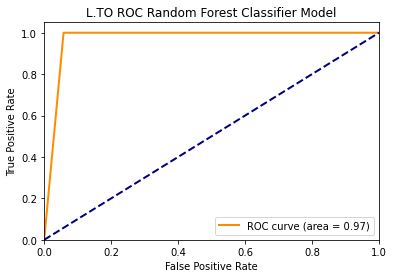

In [91]:
# Plot of a ROC curve for a specific class

plt.figure()
lw = 2 #line widthe
plt.plot(
    l_fpr,
    l_tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % l_roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("L.TO ROC Random Forest Model")
plt.legend(loc="lower right")
plt.show()

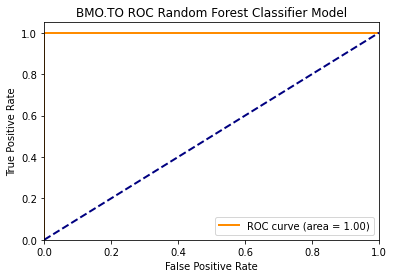

In [92]:
# Plot of a ROC curve for a specific class

plt.figure()
lw = 2 #line widthe
plt.plot(
    bmo_fpr,
    bmo_tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % bmo_roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(".TO ROC Random Forest Classifier Model")
plt.legend(loc="lower right")
plt.show()

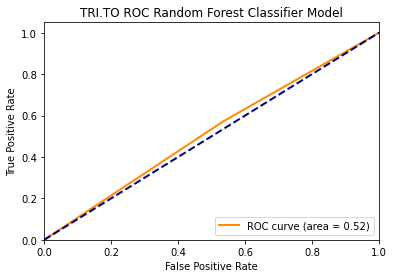

In [93]:
# Plot of a ROC curve for a specific class

plt.figure()
lw = 2 #line widthe
plt.plot(
    tri_fpr,
    tri_tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % tri_roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TRI.TO ROC Random Forest Classifier Model")
plt.legend(loc="lower right")
plt.show()

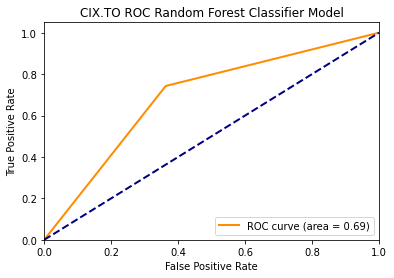

In [94]:
# Plot of a ROC curve for a specific class

plt.figure()
lw = 2 #line widthe
plt.plot(
    cix_fpr,
    cix_tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % cix_roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CIX.TO ROC Random Forest Classifier Model")
plt.legend(loc="lower right")
plt.show()

In [98]:
#Hyperperameter Algorithm:Grid search
# Define the hyperparameter configuration space

# Hyperparameterize L.TO
l_rf_params = {
    'n_estimators': [10, 20, 30],
    #'max_features': ['sqrt',0.5],
    'max_depth': [15,20,30,50],
    #'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
print('L.TO')
clf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, l_rf_params, cv=3, scoring='accuracy')
grid.fit(X_l, y_l)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

# Hyperparameterize BMO.TO
bmo_rf_params = {
    'n_estimators': [10, 20, 30],
    #'max_features': ['sqrt',0.5],
    'max_depth': [15,20,30,50],
    #'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
print('BMO.TO')
clf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, bmo_rf_params, cv=3, scoring='accuracy')
grid.fit(X_bmo, y_bmo)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

# Hyperparameterize TRI.TO
tri_rf_params = {
    'n_estimators': [10, 20, 30],
    #'max_features': ['sqrt',0.5],
    'max_depth': [15,20,30,50],
    #'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
print('TRI.TO')
clf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, tri_rf_params, cv=3, scoring='accuracy')
grid.fit(X_tri, y_tri)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))


# Hyperparameterize CIX.TO
cix_rf_params = {
    'n_estimators': [10, 20, 30],
    #'max_features': ['sqrt',0.5],
    'max_depth': [15,20,30,50],
    #'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
print('CIX.TO')
clf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, cix_rf_params, cv=3, scoring='accuracy')
grid.fit(X_cix, y_cix)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

L.TO
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 30}
Accuracy:0.9612403100775193
BMO.TO
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 10}
Accuracy:1.0
TRI.TO
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 30}
Accuracy:0.9948320413436692
CIX.TO
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 20}
Accuracy:1.0


In [95]:
# #Calculate some volume based indicators into the dataframe
# accuracy = {}
# for ticker in ticker_list:
#     stock_data = ticker_list['CIX.TO'].copy()
#     # stock_data['SMA'] = finta.TA.SMA(stock_data)
#     # stock_data['SMM'] = finta.TA.SMM(stock_data)
#     # stock_data['SSMA'] = finta.TA.SSMA(stock_data)
#     # stock_data['EMA'] = finta.TA.EMA(stock_data)
#     # stock_data['DEMA'] = finta.TA.DEMA(stock_data)
#     # stock_data['TEMA'] = finta.TA.TEMA(stock_data)
#     # stock_data['TRIMA'] = finta.TA.TRIMA(stock_data)
#     # stock_data['TRIX'] = finta.TA.TRIX(stock_data)
#     # stock_data['VAMA'] = finta.TA.VAMA(stock_data)
#     # stock_data['ER'] = finta.TA.ER(stock_data)
#     # stock_data['KAMA'] = finta.TA.KAMA(stock_data)
#     # stock_data['ZLEMA'] = finta.TA.ZLEMA(stock_data)
#     # stock_data['WMA'] = finta.TA.WMA(stock_data)
#     # stock_data['HMA'] = finta.TA.HMA(stock_data)
#     # stock_data['EVWMA'] = finta.TA.EVWMA(stock_data)
#     # stock_data['VWAP'] = finta.TA.VWAP(stock_data)
#     # stock_data['SMMA'] = finta.TA.SMMA(stock_data)
#     # stock_data['FRAMA'] = finta.TA.FRAMA(stock_data)
#     # #stock_data['MACD'] = finta.TA.MACD(stock_data)
#     # #stock_data['PPO'] = finta.TA.PPO(stock_data)
#     # #stock_data['VW_MACD'] = finta.TA.VW_MACD(stock_data)
#     # #stock_data['EV_MACD'] = finta.TA.EV_MACD(stock_data)
#     # stock_data['MOM'] = finta.TA.MOM(stock_data)
#     # stock_data['ROC'] = finta.TA.ROC(stock_data)
#     # stock_data['RSI'] = finta.TA.RSI(stock_data)
#     # stock_data['IFT_RSI'] = finta.TA.IFT_RSI(stock_data)
#     # stock_data['TR'] = finta.TA.TR(stock_data)
#     # stock_data['ATR'] = finta.TA.ATR(stock_data)
#     # stock_data['SAR'] = finta.TA.SAR(stock_data)
#     # #stock_data['BBANDS'] = finta.TA.BBANDS(stock_data)
#     # stock_data['BBWIDTH'] = finta.TA.BBWIDTH(stock_data)
#     # #stock_data['MOBO'] = finta.TA.MOBO(stock_data)
#     # stock_data['PERCENT_B'] = finta.TA.PERCENT_B(stock_data)
#     # #stock_data['KC'] = finta.TA.KC(stock_data)
#     # #stock_data['DO'] = finta.TA.DO(stock_data)
#     # #stock_data['DMI'] = finta.TA.DMI(stock_data)
#     # stock_data['ADX'] = finta.TA.ADX(stock_data)
#     # #stock_data['PIVOT'] = finta.TA.PIVOT(stock_data)
#     # #stock_data['PIVOT_FIB'] = finta.TA.PIVOT_FIB(stock_data)
#     # stock_data['STOCH'] = finta.TA.STOCH(stock_data)
#     # stock_data['STOCHD'] = finta.TA.STOCHD(stock_data)
#     # stock_data['STOCHRSI'] = finta.TA.STOCHRSI(stock_data)
#     # stock_data['WILLIAMS'] = finta.TA.WILLIAMS(stock_data)
#     # stock_data['UO'] = finta.TA.UO(stock_data)
#     # stock_data['AO'] = finta.TA.AO(stock_data)
#     # stock_data['MI'] = finta.TA.MI(stock_data)
#     # #stock_data['VORTEX'] = finta.TA.VORTEX(stock_data)
#     # #stock_data['KST'] = finta.TA.KST(stock_data)
#     # #stock_data['TSI'] = finta.TA.TSI(stock_data)
#     # stock_data['TP'] = finta.TA.TP(stock_data)
#     # stock_data['ADL'] = finta.TA.ADL(stock_data)
#     # stock_data['CHAIKIN'] = finta.TA.CHAIKIN(stock_data)
#     # stock_data['MFI'] = finta.TA.MFI(stock_data)
#     # stock_data['OBV'] = finta.TA.OBV(stock_data)
#     # stock_data['WOBV'] = finta.TA.WOBV(stock_data)
#     # stock_data['VZO'] = finta.TA.VZO(stock_data)
#     # stock_data['PZO'] = finta.TA.PZO(stock_data)
#     # stock_data['EFI'] = finta.TA.EFI(stock_data)
#     # stock_data['CFI'] = finta.TA.CFI(stock_data)
#     # #stock_data['EBBP'] = finta.TA.EBBP(stock_data)
#     # stock_data['EMV'] = finta.TA.EMV(stock_data)
#     # stock_data['CCI'] = finta.TA.CCI(stock_data)
#     # stock_data['COPP'] = finta.TA.COPP(stock_data)
#     # #stock_data['BASP'] = finta.TA.BASP(stock_data)
#     # #stock_data['BASPN'] = finta.TA.BASPN(stock_data)
#     # stock_data['CMO'] = finta.TA.CMO(stock_data)
#     # #stock_data['CHANDELIER'] = finta.TA.CHANDELIER(stock_data)
#     # stock_data['QSTICK'] = finta.TA.QSTICK(stock_data)
#     # #stock_data['TMF'] = finta.TA.TMF(stock_data)
#     # #stock_data['WTO'] = finta.TA.WTO(stock_data)
#     # stock_data['FISH'] = finta.TA.FISH(stock_data)
#     # #stock_data['ICHIMOKU'] = finta.TA.ICHIMOKU(stock_data)
#     # #stock_data['APZ'] = finta.TA.APZ(stock_data)
#     # stock_data['SQZMI'] = finta.TA.SQZMI(stock_data)
#     # stock_data['VPT'] = finta.TA.VPT(stock_data)
#     # stock_data['FVE'] = finta.TA.FVE(stock_data)
#     # stock_data['VFI'] = finta.TA.VFI(stock_data)
#     # stock_data['MSD'] = finta.TA.MSD(stock_data)
#     # stock_data['STC'] = finta.TA.STC(stock_data)
#     #stock_data['WAVEPM'] = finta.TA.WAVEPM(stock_data)
#     stock_data['SMA5'] = finta.TA.SMA(stock_data,5)
#     stock_data['SMM5'] = finta.TA.SMM(stock_data,5)
#     stock_data['SMA20'] = finta.TA.SMA(stock_data,20)
#     stock_data['SMM20'] = finta.TA.SMM(stock_data,20)
#     #stock_data['SMA50'] = finta.TA.SMA(stock_data,50)
#     #stock_data['SMM50'] = finta.TA.SMM(stock_data,50)
#     stock_data['mfi5'] = finta.TA.MFI(stock_data,5)
#     stock_data['mfi20'] = finta.TA.MFI(stock_data,20)
#     #stock_data['mfi50'] = finta.TA.MFI(stock_data,50)
#     stock_data['mom5'] = finta.TA.MOM(stock_data,5)
#     stock_data['mom20'] = finta.TA.MOM(stock_data,20)
#     #stock_data['mom50'] = finta.TA.MOM(stock_data,50)
#     stock_data['rsi5'] = finta.TA.RSI(stock_data,5)
#     stock_data['rsi20'] = finta.TA.RSI(stock_data,20)
#     #stock_data['rsi50'] = finta.TA.RSI(stock_data,50)
#     stock_data['chaikin5'] = finta.TA.CHAIKIN(stock_data,5)
#     stock_data['chaikin20'] = finta.TA.CHAIKIN(stock_data,20)
#     #stock_data['chaikin50'] = finta.TA.CHAIKIN(stock_data,50)
#     #https://www.investopedia.com/top-7-technical-analysis-tools-4773275
#     #stock_data['obv'] = finta.TA.OBV(stock_data)
#     stock_data['adl'] = finta.TA.ADL(stock_data)
#     stock_data['adx5'] = finta.TA.ADX(stock_data,5)
#     stock_data['adx20'] = finta.TA.ADX(stock_data,20)
#     #stock_data['adx50'] = finta.TA.ADX(stock_data,50)
#     #stock_data['macd'] = finta.TA.MACD(stock_data)
#     stock_data['stoch'] = finta.TA.STOCH(stock_data)
#     #High minus low = new feature (custom loss functions for predictions)
#     #window_size = 20
#     #window_to_adjust = 'Volume'
#     #window_name = window_to_adjust + str(window_size) 
#     #stock_data[window_name] = stock_data[window_to_adjust].rolling(window=window_size).mean().pct_change().shift(-window_size)
#     stock_data.dropna(inplace = True)
#     stock_data['close_change'] = stock_data['Close'].pct_change().shift(-1)
#     stock_data['Signal'] = np.where(
#     stock_data['close_change'] > 0, 1.0, 0.0)
#     full_df = stock_data.copy()
#     full_df.to_csv("full_df.csv")
#     #stock_data.drop(["Open", "High","Adj Close","Low","Close","Volume"], axis = 1, inplace = True)
#     #print(stock_data.head())

#     #Get features and label dataframe
#     X = stock_data.copy().drop(['close_change','Signal'],axis=1)
#     y = stock_data['Signal'].copy()
#     # Select the start of the training period
#     training_begin = X.index.min()

#     # Display the training begin date
#     print(ticker, training_begin)
#     training_end = training_begin + DateOffset(days=len(y)*.5)

#     # Display the training end date
#     #print(training_end)
#     # Generate the X_train and y_train DataFrames
#     X_train = X.loc[:training_end]
#     y_train = y.loc[:training_end]

#     # Review the X_train DataFrame
#     X_train.tail()
#     # Generate the X_test and y_test DataFrames
#     X_test = X.loc[training_end:]
#     y_test = y.loc[training_end:]
#     # Scale the features DataFrames

#     # Create a StandardScaler instance
#     scaler = StandardScaler()

#     # Apply the scaler model to fit the X-train data
#     X_scaler = scaler.fit(X_train)

#     # Transform the X_train and X_test DataFrames using the X_scaler
#     X_train_scaled = X_scaler.transform(X_train)
#     X_test_scaled = X_scaler.transform(X_test)
#     svm_model = svm.SVC()
#     rfc_model = RandomForestClassifier() 
#     lr_model = LogisticRegression()
#     # Fit the model to the data using the training data
#     ml_list = [svm_model, rfc_model, lr_model]
#     for model in ml_list:
#         model = model.fit(X_train_scaled, y_train)
#         # Use the testing data to make the model predictions
#         predictions = model.predict(X_test_scaled)

#         # Review the model's predicted values
#         # Use a classification report to evaluate the model using the predictions and testing data
#         testing_report = classification_report(
#             y_test, predictions, output_dict = True)

#         # Print the classification report
#         #print(testing_report)
#         temp = pd.DataFrame( data ={'testing':y_test, 'predictions':predictions})
#         accuracy[ticker + "-" + model.__class__.__name__] = testing_report['accuracy']
#     voting_clf = VotingClassifier(estimators = [('SVM',svm_model),("RFC",rfc_model),("lr",lr_model)])
#     voting_clf.fit(X_train_scaled,y_train)
#     vote_preds = voting_clf.predict(X_test_scaled)
#     vote_accuracy = accuracy_score(y_test, vote_preds)
#     print(ticker + " voting score " + str(vote_accuracy))

# print(accuracy)